# Building scenarios

Pymagicc offers the ability to join/merge scenarios to create custom scenarios. Here we show a minimal working example of how to do this.

In [1]:
from os.path import join

from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, join_timeseries
from pymagicc.definitions import (
    convert_magicc7_to_openscm_variables, 
    PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
)

import expectexception

import matplotlib.pyplot as plt
plt.style.use('bmh') 
%matplotlib inline

In [2]:
DATA_DIR = join("..", "tests", "test_data")
DATA_MAGICC6_RUN = join("..", "pymagicc", "MAGICC6", "run")

Firstly we read in the timeseries we want to merge.

In [3]:
rcp = MAGICCData()
rcp.read(join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"))
base = rcp.df

rcp.read(join(DATA_MAGICC6_RUN, "RCP85.SCEN"))
scen = rcp.df

If we try to merge them now, we will receive an error as they have no overlapping indices. 

In [4]:
%%expect_exception ValueError
join_timeseries(base, scen)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-4-03cf48bb256b> in <module>
----> 1 join_timeseries(base, scen)

~/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py in join_timeseries(base, overwrite, join_linear)
   2165             raise ValueError("join_linear must have a length of 2")
   2166 
-> 2167     result = _join_timeseries_mdata(base, overwrite, join_linear)
   2168 
   2169     return result

~/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py in _join_timeseries_mdata(base, overwrite, join_linear)
   2179 
   2180     if result.stack().index.intersection(ow.stack().index).empty:
-> 2181         raise ValueError("No overlapping indices, a simple append will do")
   2182 
   2183     result.update(ow, raise_conflict=False)

ValueError: No overlapping indices, a simple append will do


The reason for this is that the data from RCP3PD is read in with the "todo" column set to "N/A" whilst the data read in from the SCEN file is read in with the "todo" column set to "SET".

In [ ]:
base.head()

,variable,todo,unit,region,time,value
0,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1765,0.003
1,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1766,0.003
2,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1767,0.003
3,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1768,0.003
4,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1769,0.003


In [ ]:
scen.head()

,variable,todo,unit,region,time,value
0,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2000,0.0
1,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2001,0.0
2,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2002,0.0
3,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2003,0.0
4,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2004,0.0


We can rectify this by setting the todo column of base.

In [ ]:
base["todo"] = "SET"
base.head()

,variable,todo,unit,region,time,value
0,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World,1765,0.003
1,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World,1766,0.003
2,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World,1767,0.003
3,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World,1768,0.003
4,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World,1769,0.003


Now the timeseries will join smoothly. In this case we will overwrite the base values with the scen values wherever they are provided. Also note that the output timeseries are inearly interpolated onto annual timesteps (unlike the input SCEN files which have irregular timesteps).

In [ ]:
my_scen = join_timeseries(base, scen)
my_scen["time"].unique()

array([1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775,
       1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786,
       1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797,
       1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808,
       1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819,
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830,
       1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841,
       1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852,
       1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863,
       1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874,
       1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896,
       1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
       1908, 1909, 1910, 1911, 1912, 1913, 1914, 19

Note that only variable-region-unit combinations which are included in the base dataframe will be included in the resulting dataframe. Hence the output dataframe will not include the regional data from the scen file (downscaling is another issue entirely).

In [ ]:
my_scen[my_scen["region"] == "R5OECD"]

,todo,unit,variable,region,time,value


We can check the results as shown.

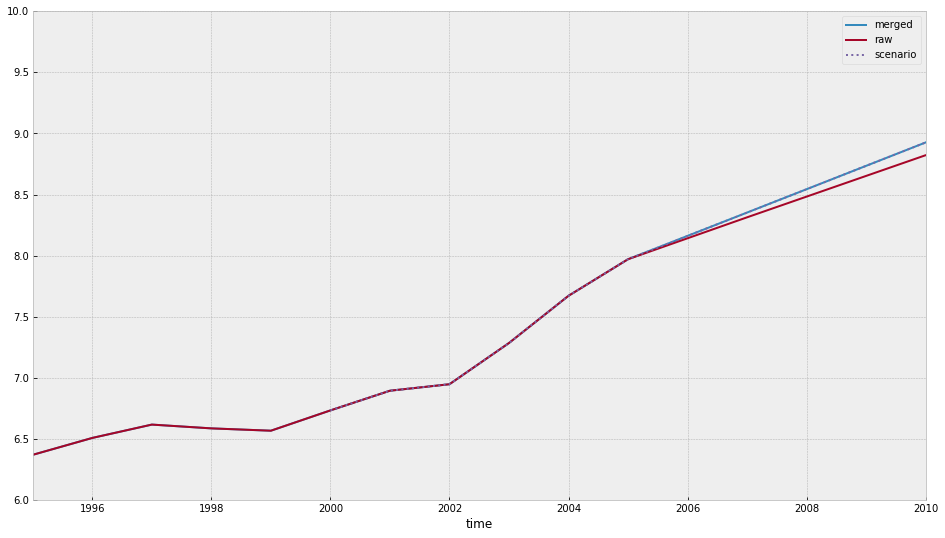

In [ ]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = my_scen[
    my_scen["variable"] == var_to_plot
].plot(x="time", y="value", label="merged", figsize=(16, 9))
base[
    (base["variable"] == var_to_plot)
    & (base["region"] == "World")
].plot(x="time", y="value", label="raw", ax=ax)
scen[
    (scen["variable"] == var_to_plot)
    & (scen["region"] == "World")
].plot(x="time", y="value", label="scenario", ls=":", ax=ax)
ax.set_xlim([1995, 2010])
ax.set_ylim([6, 10]);

If we put our scenario into a MAGICCData object and select only the variables which are used in SCEN files, we can then run it using Pymagicc.

In [ ]:
# scen_vars = convert_magicc7_to_openscm_variables(
#     [v + "_EMIS" for v in PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1]
# )

magicc_scen = MAGICCData()
magicc_scen.df = my_scen#[my_scen["variable"].isin(scen_vars)].copy()
for v in ["variable", "region", "todo", "unit"]:
    magicc_scen.df.loc[:, v] = magicc_scen.df[v].astype(str)
    
with MAGICC6() as magicc:
    results = magicc.run(magicc_scen)

/Users/zebedeenicholls/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py:1506: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


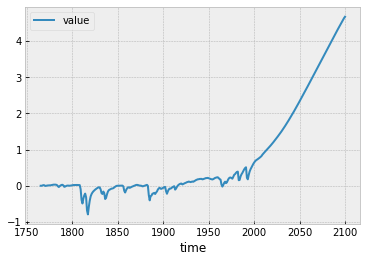

In [ ]:
results.df[
    (results.df["variable"] == "Surface Temperature")
    & (results.df["region"] == "World")
].plot(x="time", y="value");

We can also join the timeseries with a linear join period. This allows us to use some base scenario, overwrite with a multitude of other scenarios but ensure they all have a common historical period and some roughly smooth transition. At the moment the linear join period is the only option, a far more complete would be to use the [Aneris](https://github.com/iiasa/aneris) package but this would be a far more difficult step.

In [ ]:
linear_scen = join_timeseries(base, scen, join_linear=[2000, 2010])
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = linear_scen[
    linear_scen["variable"] == var_to_plot
].plot(x="time", y="value", label="merged", figsize=(16, 9))
base[
    (base["variable"] == var_to_plot)
    & (base["region"] == "World")
].plot(x="time", y="value", label="raw", ax=ax)
scen[
    (scen["variable"] == var_to_plot)
    & (scen["region"] == "World")
].plot(x="time", y="value", label="scenario", ls=":", ax=ax)
ax.set_xlim([1995, 2015])
ax.set_ylim([6, 10]);

In [ ]:
scen_vars = convert_magicc7_to_openscm_variables(
    [v + "_EMIS" for v in PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1]
)

magicc_scen = MAGICCData()
magicc_scen.df = linear_scen[linear_scen["variable"].isin(scen_vars)].copy()
for v in ["variable", "region", "todo", "unit"]:
    magicc_scen.df.loc[:, v] = magicc_scen.df[v].astype(str)
    
with MAGICC6() as magicc:
    results = magicc.run(magicc_scen)

In [ ]:
results.df[
    (results.df["variable"] == "Surface Temperature")
    & (results.df["region"] == "World")
].plot(x="time", y="value");